## Stax MLP on b-mnist 

In [1]:
!pip install rsbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from rsbox import ml, misc

In [3]:
dset = misc.load_dataset("https://stanford.edu/~rsikand/assets/datasets/mini_binary_mnist.pkl")

In [4]:
dset[0][0].shape

(1, 28, 28)

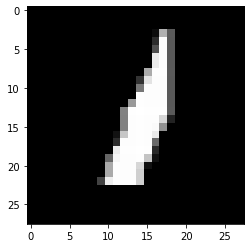

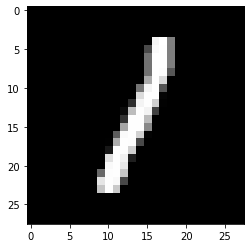

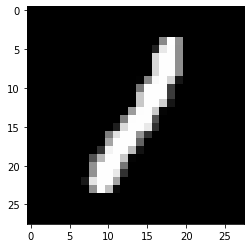

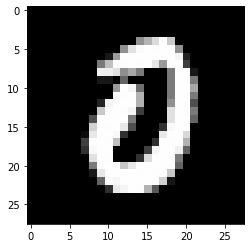

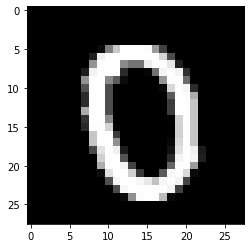

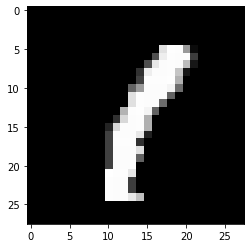

In [5]:
# plot some samples
for i, elem in enumerate(dset):
  if i > 5:
    break
  ml.plot(elem[0], color=False)

## Model 

In [16]:
import jax.numpy as jnp
from jax import random
from jax.example_libraries import stax
from jax.example_libraries.stax import (
    Dense, Relu, Flatten, Sigmoid)

# Use stax to set up network initialization and evaluation functions
net_init, net_apply = stax.serial(
    Flatten,
    Dense(1*28*28), Relu,
    Dense(128), Relu,
    Dense(64), Relu,
    Dense(1), Sigmoid
)

# Initialize parameters, not committing to a batch shape
rng = random.PRNGKey(0)
in_shape = (-1, 1, 28, 28)
out_shape, net_params = net_init(rng, in_shape)

In [17]:
# Apply network to dummy inputs
inputs = jnp.ones((4, 1, 28, 28))
predictions = net_apply(net_params, inputs)

In [18]:
print(predictions, "\n -")
print((predictions > 0.5).astype(float))

[[0.7324219]
 [0.7324219]
 [0.7324219]
 [0.7324219]] 
 -
[[1.]
 [1.]
 [1.]
 [1.]]


In [19]:
print(type(net_params))
print(type(net_params[1]))

<class 'list'>
<class 'tuple'>


The params are a list of tuples. 

In [20]:
net_apply(net_params, jnp.ones((1, 28, 28)))

DeviceArray([[0.7324219]], dtype=float32)

Hmmm... how does that handle auto-batching without a vmap? 

In [21]:
gradient_step = lambda p, g, lr: p - lr * g

In [24]:
from jax import nn
import jax

In [26]:
bce_loss = lambda logits, y: -(y * jax.nn.log_sigmoid(logits) + (1 - y) * jax.nn.log_sigmoid(1-logits)) 

In [27]:
!pip install optax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 154 kB 5.2 MB/s 
     |████████████████████████████████| 85 kB 4.3 MB/s 


In [28]:
 predictions

DeviceArray([[0.7324219],
             [0.7324219],
             [0.7324219],
             [0.7324219]], dtype=float32)

In [30]:
ys = jnp.array([1,1,1,1])

In [35]:
from jax import grad, jit, vmap

In [33]:
import optax
optax.sigmoid_binary_cross_entropy(predictions[0], ys[0])

DeviceArray([0.39254418], dtype=float32)

In [46]:
bce_loss(predictions, ys)

DeviceArray([[0.39254418, 0.39254418, 0.39254418, 0.39254418],
             [0.39254418, 0.39254418, 0.39254418, 0.39254418],
             [0.39254418, 0.39254418, 0.39254418, 0.39254418],
             [0.39254418, 0.39254418, 0.39254418, 0.39254418]],            dtype=float32)

In [37]:
from jax import grad, jit, vmap

In [48]:
bce_batched = vmap(bce_loss)

In [63]:
def stateless_loss(params, net_apply, loss_function, x, y):
  model_preds = net_apply(params, x)
  loss_value = loss_function(model_preds, y)
  return jnp.squeeze(loss_value)

In [64]:
from jax import value_and_grad, tree_util

In [65]:
from rsbox import ml, misc

In [69]:
@jax.jit
def update_step(params, grads, lr):
    """
    Updates params via one step of gradient descent. 
    Arguments: 
    -----------
    - params: pytree of parameters for the net 
    - grads: gradient of loss wrt to params 
    - lr: learning rate (step size) 
    Returns: 
    -----------
    loss_value: updated params  
    """
    gradient_step = lambda p, g: p - lr * g   
    return tree_util.tree_map(gradient_step, params, grads)

In [70]:
num_epochs = 10
learning_rate = 0.01
loss_metric = ml.MeanMetric()



for i in range(num_epochs):
  loss_metric.reset()
  for batch in dset:
    x, y = batch
    loss_val, grads = value_and_grad(stateless_loss)(net_params, net_apply, bce_loss, x, y)
    loss_metric.update(loss_val)
    net_params = update_step(net_params, grads, learning_rate)
  
  epoch_loss = loss_metric.get()
  print(f"Loss (epoch {i}): ", epoch_loss)

Loss (epoch 0):  0.43531743
Loss (epoch 1):  0.37873676
Loss (epoch 2):  0.34777504
Loss (epoch 3):  0.33328837
Loss (epoch 4):  0.32626435
Loss (epoch 5):  0.322431
Loss (epoch 6):  0.32013223
Loss (epoch 7):  0.31864673
Loss (epoch 8):  0.31762904
Loss (epoch 9):  0.3169005
